### City2Graph: Mobility Graph Construction from Carris Bus Data

*Adapted from: [city2graph.net/examples/gtfs.html](https://city2graph.net/examples/gtfs.html)*

In this notebook, we adapt the City2Graph methodology to construct a **mobility network** based on Carris public transport data in Lisbon. Instead of using GTFS feeds, we use **empirical bus trajectories**, including actual vehicle stop events and routes, to model real-world urban mobility flows.

Our pipeline includes:
- Processing raw Carris bus data to extract individual trips between stops.
- Aggregating observed trips to build a directed, weighted graph.
- Nodes represent bus stops; edges represent mobility flows (i.e., trips between stops).
- Edge weights correspond to the frequency of observed transitions between locations.
- Visualizing and analyzing the resulting graph to study urban mobility structure and connectivity.

This approach allows us to study public transport mobility as a complex network and provides a basis for applying graph-theoretic or machine learning techniques (e.g., community detection, graph embeddings) to transportation data.

In [2]:
# Geospatial data processing
import geopandas as gpd
import networkx as nx

# Mapping and visualization
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Network analysis
import osmnx as ox

# The star of the show: city2graph for transportation network analysis
import city2graph
import pandas as pd

/Users/kfilonchik/anaconda3/envs/graph_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import geopandas as gpd

In [4]:
from pathlib import Path
import city2graph

# Load GTFS data - city2graph handles all the complexity!
sample_gtfs_path = Path("data/out/gtfs.zip")

print("Loading Lisbon Transport GTFS data...")
print("This includes buses, trains, tubes, and trams across Greater London")

# One function call loads and processes the entire GTFS dataset
gtfs_data = city2graph.load_gtfs(sample_gtfs_path)

print(f"GTFS data loaded successfully!")
print(f"Found {len(gtfs_data)} data tables")
print(f"Total stops: {len(gtfs_data['stops']):,}")
print(f"Total routes: {len(gtfs_data['routes']):,}")
print(f"Total scheduled stop times: {len(gtfs_data['stop_times']):,}")

Loading Lisbon Transport GTFS data...
This includes buses, trains, tubes, and trams across Greater London
GTFS data loaded successfully!
Found 6 data tables
Total stops: 12,685
Total routes: 690
Total scheduled stop times: 4,515,685


In [ ]:
gtfs_data = pd.read_csv("data/out/routes.csv")

/var/folders/hh/pvwk6s4917qdt0_j791cx6wc0000gn/T/ipykernel_11255/4062594596.py:1: DtypeWarning: Columns (23,40,43,44,66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  gtfs_data = pd.read_csv("data/out/routes.csv")


In [6]:
stops_gdf = gpd.GeoDataFrame(
    gtfs_data, geometry=gpd.points_from_xy(gtfs_data.stop_lon, gtfs_data.stop_lat), crs="EPSG:4326"
)

In [8]:
stops = stops_gdf[['stop_id', 'stop_name', 'geometry']].drop_duplicates().reset_index(drop=True)

In [9]:
stops

stop_id                                          stop_name  \
0         20028             ALMADA (R BERNARDO FRANCISCO COSTA 73)   
1         20031                ALMADA PRAÇA GIL VICENTE 4 (ESCOLA)   
2         20033              CACILHAS AV 25 ABRIL 45C (SEG SOCIAL)   
3         20035                         CACILHAS (AV 25 ABRIL N3A)   
4         20039                          CACILHAS (AV 25 ABRIL N6)   
...         ...                                                ...   
267704   162003  Interface de Transportes de Setúbal (Terminal) P3   
267705   162004  Interface de Transportes de Setúbal (Terminal) P4   
267706   162005                          Setúbal (ITS) Interior P5   
267707   162007             Interface de Transportes de Setúbal P7   
267708   162008  Interface de Transportes de Setúbal (Terminal) P8   

                         geometry  
0        POINT (-9.1573 38.68107)  
1       POINT (-9.15397 38.68224)  
2        POINT (-9.1519 38.68266)  
3       POINT (-9.14969 38.68422)  
4       POINT (-9.14732 38.68797)  
...                           ...  
267704  POINT (-8.88659 38.52803)  
267705  POINT (-8.88579 38.52957)  
267706   POINT (-8.88187 38.5292)  
267707   POINT (-8.88613 38.5289)  
267708  POINT (-8.88616 38.52927)  

[267709 rows x 3 columns]

In [ ]:
stops_web = stops.to_crs(epsg=3857)

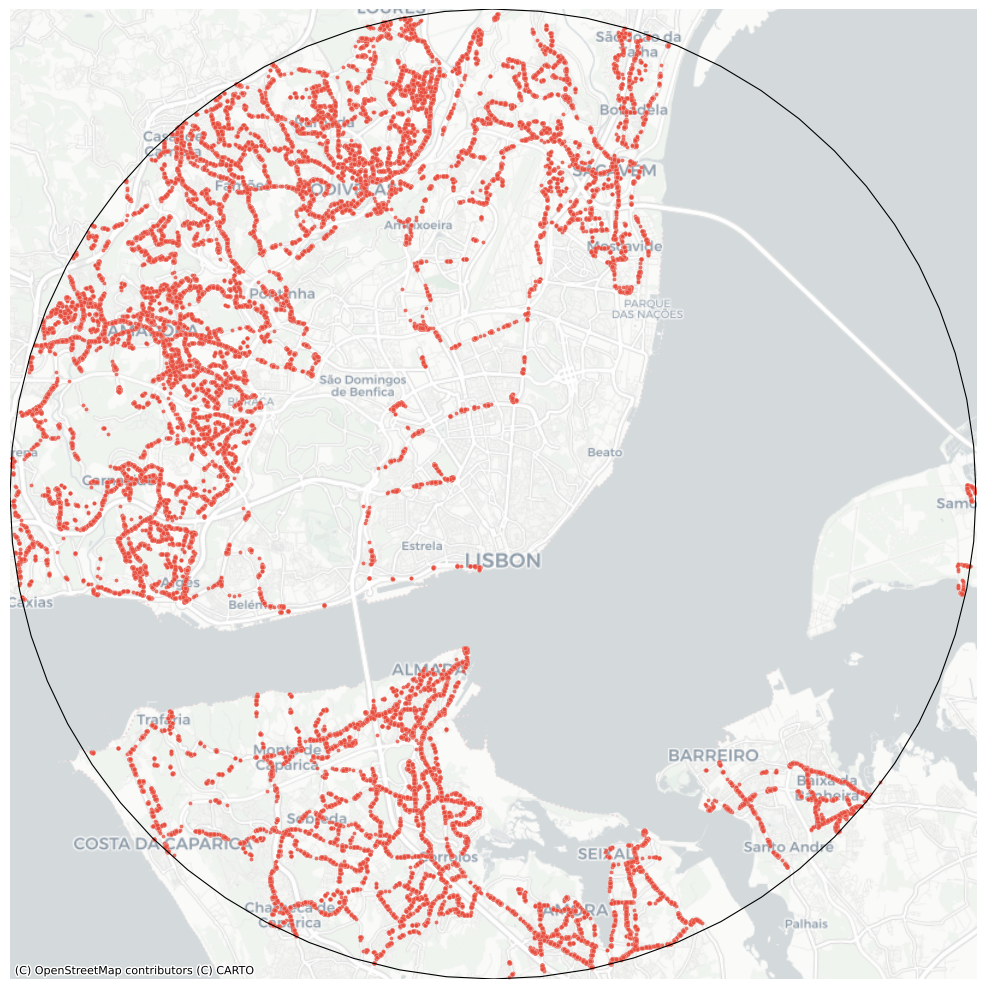

In [18]:
import pyproj
from shapely.geometry import Point

# Lisbon center in WGS84
lon0, lat0 = -9.1393, 38.7223

# Build a circle in meters using UTM 29N for Lisbon, then transform to 3857
center_utm = gpd.GeoSeries([Point(lon0, lat0)], crs=4326).to_crs(32629)
roi_utm = center_utm.buffer(12_000)  # 12 km
roi_web = roi_utm.to_crs(3857)

stops_web = stops.to_crs(3857)
# Optional: keep only points within the ROI
stops_web_clip = stops_web[stops_web.intersects(roi_web.iloc[0])]

fig, ax = plt.subplots(figsize=(12,10))
stops_web_clip.plot(ax=ax, alpha=0.8, markersize=8, color="#e74c3c", edgecolor="white", linewidth=0.1)
roi_web.boundary.plot(ax=ax, color="black", linewidth=0.8)

minx, miny, maxx, maxy = roi_web.total_bounds
ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)

import contextily as ctx
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.tight_layout()
plt.show()


In [5]:
# Transform GTFS schedules into a travel network graph
print("Converting GTFS schedules to network representation...")
print("This processes thousands of trips into clean origin-destination relationships")

# The magic happens here - one function call does all the heavy lifting!
travel_summary_nodes, travel_summary_edges = city2graph.travel_summary_graph(
    gtfs_data
)

print("Network analysis complete!")
print(f"Created graph with:")
print(f"   • {len(travel_summary_nodes):,} nodes (stops with connections)")
print(f"   • {len(travel_summary_edges):,} edges (stop-to-stop connections)")
print(f"   • Each edge contains travel time and frequency data")

print("\nWhat city2graph calculated:")
print("   • Average travel time between each pair of connected stops")
print("   • Service frequency (trips per day) for each connection")
print("   • Spatial geometry for mapping and analysis")
print("   • Only includes stops that actually have transit service")

Converting GTFS schedules to network representation...
This processes thousands of trips into clean origin-destination relationships
Network analysis complete!
Created graph with:
   • 12,685 nodes (stops with connections)
   • 159,487 edges (stop-to-stop connections)
   • Each edge contains travel time and frequency data

What city2graph calculated:
   • Average travel time between each pair of connected stops
   • Service frequency (trips per day) for each connection
   • Spatial geometry for mapping and analysis
   • Only includes stops that actually have transit service


In [6]:
# Examine the edges (connections) in our travel network
print("Network Edges (Transit Connections):")
print("Each row represents a direct connection between two stops")
print("\nKey metrics city2graph calculated:")
print("   • mean_travel_time: Average time to travel between stops (seconds)")
print("   • frequency: Number of services per day on this connection")
print("   • geometry: LineString for mapping and spatial analysis")

print(f"\nPerformance insight:")
print(f"   Fastest connection: {travel_summary_edges['mean_travel_time'].min():.0f} seconds")
print(f"   Busiest connection: {travel_summary_edges['frequency'].max():.0f} services/day")
print(f"   Average travel time: {travel_summary_edges['mean_travel_time'].mean():.0f} seconds")

travel_summary_edges.head()

Network Edges (Transit Connections):
Each row represents a direct connection between two stops

Key metrics city2graph calculated:
   • mean_travel_time: Average time to travel between stops (seconds)
   • frequency: Number of services per day on this connection
   • geometry: LineString for mapping and spatial analysis

Performance insight:
   Fastest connection: 1 seconds
   Busiest connection: 18579 services/day
   Average travel time: 832 seconds


mean_travel_time  frequency  \
from_stop_id to_stop_id                                
100001       100001             37.983471        121   
             100011           1834.000000          1   
             100021           1455.125000          8   
             100023           1589.666667          3   
             100025           1677.000000          2   

                                                                  geometry  
from_stop_id to_stop_id                                                     
100001       100001      LINESTRING (-8.95406 38.70053, -8.95406 38.70053)  
             100011      LINESTRING (-8.95406 38.70053, -8.97065 38.70406)  
             100021      LINESTRING (-8.95406 38.70053, -8.97292 38.71286)  
             100023      LINESTRING (-8.95406 38.70053, -8.97311 38.71157)  
             100025        LINESTRING (-8.95406 38.70053, -8.9735 38.7102)

In [10]:
import geopandas as gpd
import osmnx as ox
import pandas as pd

print("Applying spatial filter to focus on Lisbon...")
print("This demonstrates city2graph's seamless integration with geospatial analysis")

# --- 1) Get Lisbon boundary ---
# For city centre only:
# lisbon_boundary = ox.geocode_to_gdf("Lisboa, Portugal").to_crs(epsg=3857)
# For the whole Lisbon Metropolitan Area:
lisbon_boundary = ox.geocode_to_gdf("Área Metropolitana de Lisboa, Portugal").to_crs(epsg=3857)

# --- 2) Project to Web Mercator for basemap/sjoin compatibility ---
travel_summary_nodes = travel_summary_nodes.to_crs(epsg=3857)
travel_summary_edges = travel_summary_edges.to_crs(epsg=3857)

# --- 3) Spatial join to keep only features inside boundary ---
print("Filtering nodes and edges within Lisbon boundary...")
nodes_before = len(travel_summary_nodes)
edges_before = len(travel_summary_edges)

nodes_in_bound = gpd.sjoin(
    travel_summary_nodes, lisbon_boundary[["geometry"]],
    how="inner", predicate="intersects"
)
if "index_right" in nodes_in_bound.columns:
    nodes_in_bound = nodes_in_bound.drop(columns=["index_right"])

edges_in_bound = gpd.sjoin(
    travel_summary_edges, lisbon_boundary[["geometry"]],
    how="inner", predicate="intersects"
)
if "index_right" in edges_in_bound.columns:
    edges_in_bound = edges_in_bound.drop(columns=["index_right"])

# --- 4) Keep only edges whose endpoints are still present ---
end_from, end_to = "from_stop_id", "to_stop_id"

# Determine valid node ids
if "stop_id" in nodes_in_bound.columns:
    valid_nodes = set(nodes_in_bound["stop_id"].astype(str))
else:
    valid_nodes = set(nodes_in_bound.index.astype(str))

# Ensure endpoint columns are strings
for c in [end_from, end_to]:
    if c in edges_in_bound.columns:
        edges_in_bound[c] = edges_in_bound[c].astype(str)

# Filter edges
if {end_from, end_to}.issubset(edges_in_bound.columns):
    travel_summary_edges = edges_in_bound[
        edges_in_bound[end_from].isin(valid_nodes) &
        edges_in_bound[end_to].isin(valid_nodes)
    ]
else:
    # fallback if MultiIndex
    mi = edges_in_bound.index
    if isinstance(mi, pd.MultiIndex) and {"from_stop_id","to_stop_id"}.issubset(mi.names):
        travel_summary_edges = edges_in_bound[
            mi.get_level_values("from_stop_id").astype(str).isin(valid_nodes) &
            mi.get_level_values("to_stop_id").astype(str).isin(valid_nodes)
        ]
    else:
        raise ValueError("Edge endpoints not found (need from_stop_id/to_stop_id columns or MultiIndex).")

# --- 5) Restrict nodes to those referenced by edges ---
if "stop_id" in nodes_in_bound.columns:
    used_nodes = set(travel_summary_edges[end_from]) | set(travel_summary_edges[end_to])
    travel_summary_nodes = nodes_in_bound[nodes_in_bound["stop_id"].astype(str).isin(used_nodes)]
else:
    travel_summary_nodes = nodes_in_bound

# --- 6) Report ---
nodes_after = len(travel_summary_nodes)
edges_after = len(travel_summary_edges)
node_reduction = (1 - nodes_after / max(nodes_before, 1)) * 100
edge_reduction = (1 - edges_after / max(edges_before, 1)) * 100

print("Spatial filtering complete:")
print(f"   Nodes within Lisbon: {nodes_after:,} (↓ {node_reduction:.1f}% from {nodes_before:,})")
print(f"   Edges within Lisbon: {edges_after:,} (↓ {edge_reduction:.1f}% from {edges_before:,})")



Applying spatial filter to focus on Lisbon...
This demonstrates city2graph's seamless integration with geospatial analysis
Filtering nodes and edges within Lisbon boundary...
Spatial filtering complete:
   Nodes within Lisbon: 12,557 (↓ 1.0% from 12,685)
   Edges within Lisbon: 159,225 (↓ 0.2% from 159,487)


Creating advanced network visualization...
This map shows the power of city2graph's transit network representation
Visualizing 60,719 transit connections
Features:
   • Line color: Travel time (darker = faster)
   • Line width: Service frequency (thicker = more frequent)
   • Geographic accuracy: Projected coordinate system
Network visualization complete!
Insights visible:
   • High-frequency corridors (thick lines)
   • Fast connections (dark lines)
   • Network density patterns across London


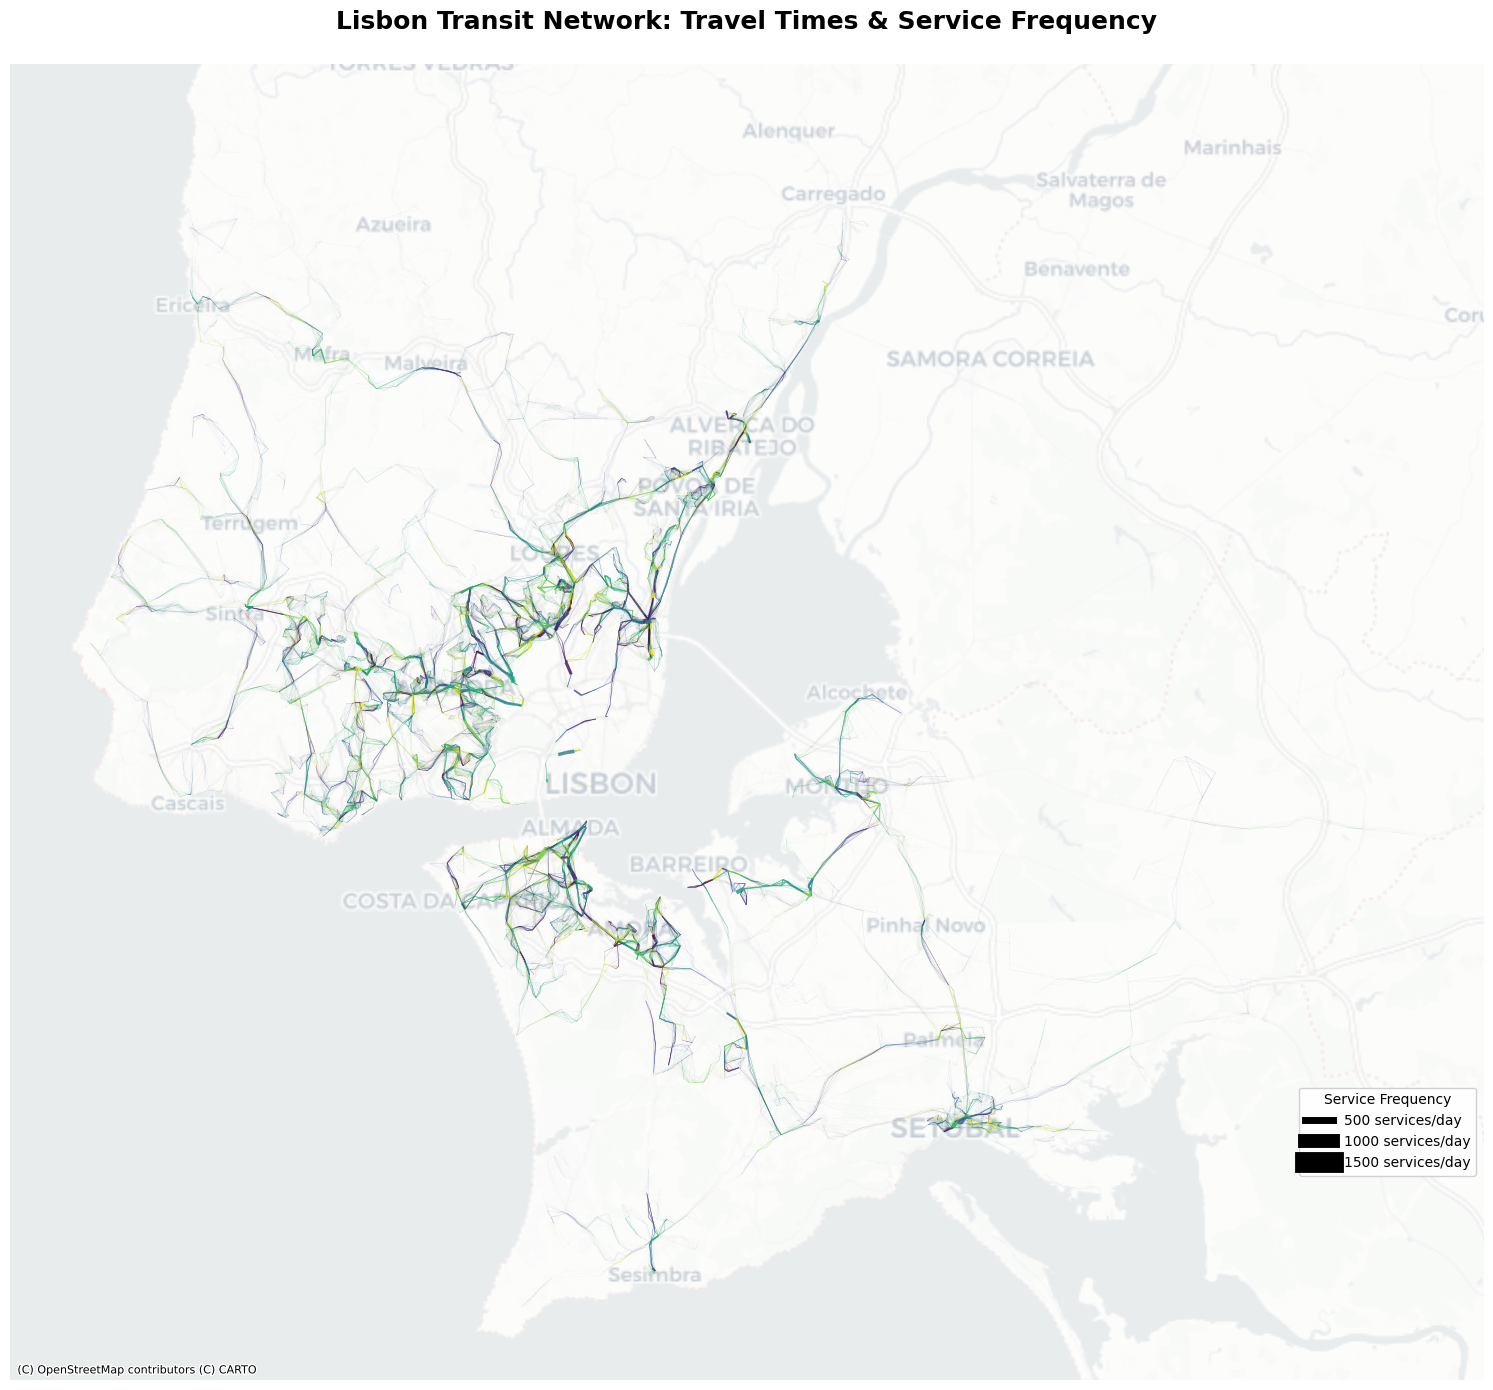

In [ ]:
# Create a sophisticated network visualization
print("Creating advanced network visualization...")
print("This map shows the power of city2graph's transit network representation")

# Filter for reasonable travel times and prepare for visualization
edges_for_viz = edges_in_bound[edges_in_bound["mean_travel_time"] < 300]  # Under 5 minutes
edges_cropped = gpd.sjoin(
    edges_for_viz,
    lisbon_boundary,
    how="inner",
    predicate="within"
)

print(f"Visualizing {len(edges_cropped):,} transit connections")
print("Features:")
print("   • Line color: Travel time (darker = faster)")
print("   • Line width: Service frequency (thicker = more frequent)")
print("   • Geographic accuracy: Projected coordinate system")

# Set up the visualization
cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(18, 14))

# Plot the network with dual encoding (color + width)
edges_cropped.plot(
   # column="mean_travel_time",
    cmap=cmap,
    scheme="quantiles",
    k=5,
    linewidth=edges_cropped['frequency'] / 250,  # Frequency determines line width
    alpha=0.8,
    ax=ax,
    legend=True,
    legend_kwds={'title': 'Average Travel Time (seconds)', 'loc': 'lower right'}
)

# Customize the travel time legend
#travel_time_legend = ax.get_legend()
#travel_time_legend.set_bbox_to_anchor((1, 0))
#travel_time_legend.set_loc('lower right')

# Add frequency legend
freq_values = [500, 1000, 1500]
freq_legend_elements = [
    mlines.Line2D([0], [0], color='black', linewidth=f/250, label=f'{f} services/day')
    for f in freq_values
]
freq_legend = ax.legend(
    handles=freq_legend_elements,
    title="Service Frequency",
    loc="lower right",
    bbox_to_anchor=(1, 0.15),
    frameon=True,
    framealpha=0.9
)
#ax.add_artist(travel_time_legend)

# Add basemap for context
ctx.add_basemap(
    ax,
    crs=edges_cropped.crs.to_string(),
    source=ctx.providers.CartoDB.Positron,
    alpha=0.5
)

# Professional styling
ax.set_title("Lisbon Transit Network: Travel Times & Service Frequency",
             fontsize=18, fontweight='bold', pad=25)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

# Clean border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('#333333')

ax.set_aspect("equal")
ax.set_axis_off()
plt.tight_layout()

print("Network visualization complete!")
print("Insights visible:")
print("   • High-frequency corridors (thick lines)")
print("   • Fast connections (dark lines)")
print("   • Network density patterns across London")

plt.show()

Visualizing 157,993 transit connections
Features:
   • Line color: Black (no travel time encoding)
   • Line width: Service frequency (thicker = more frequent)


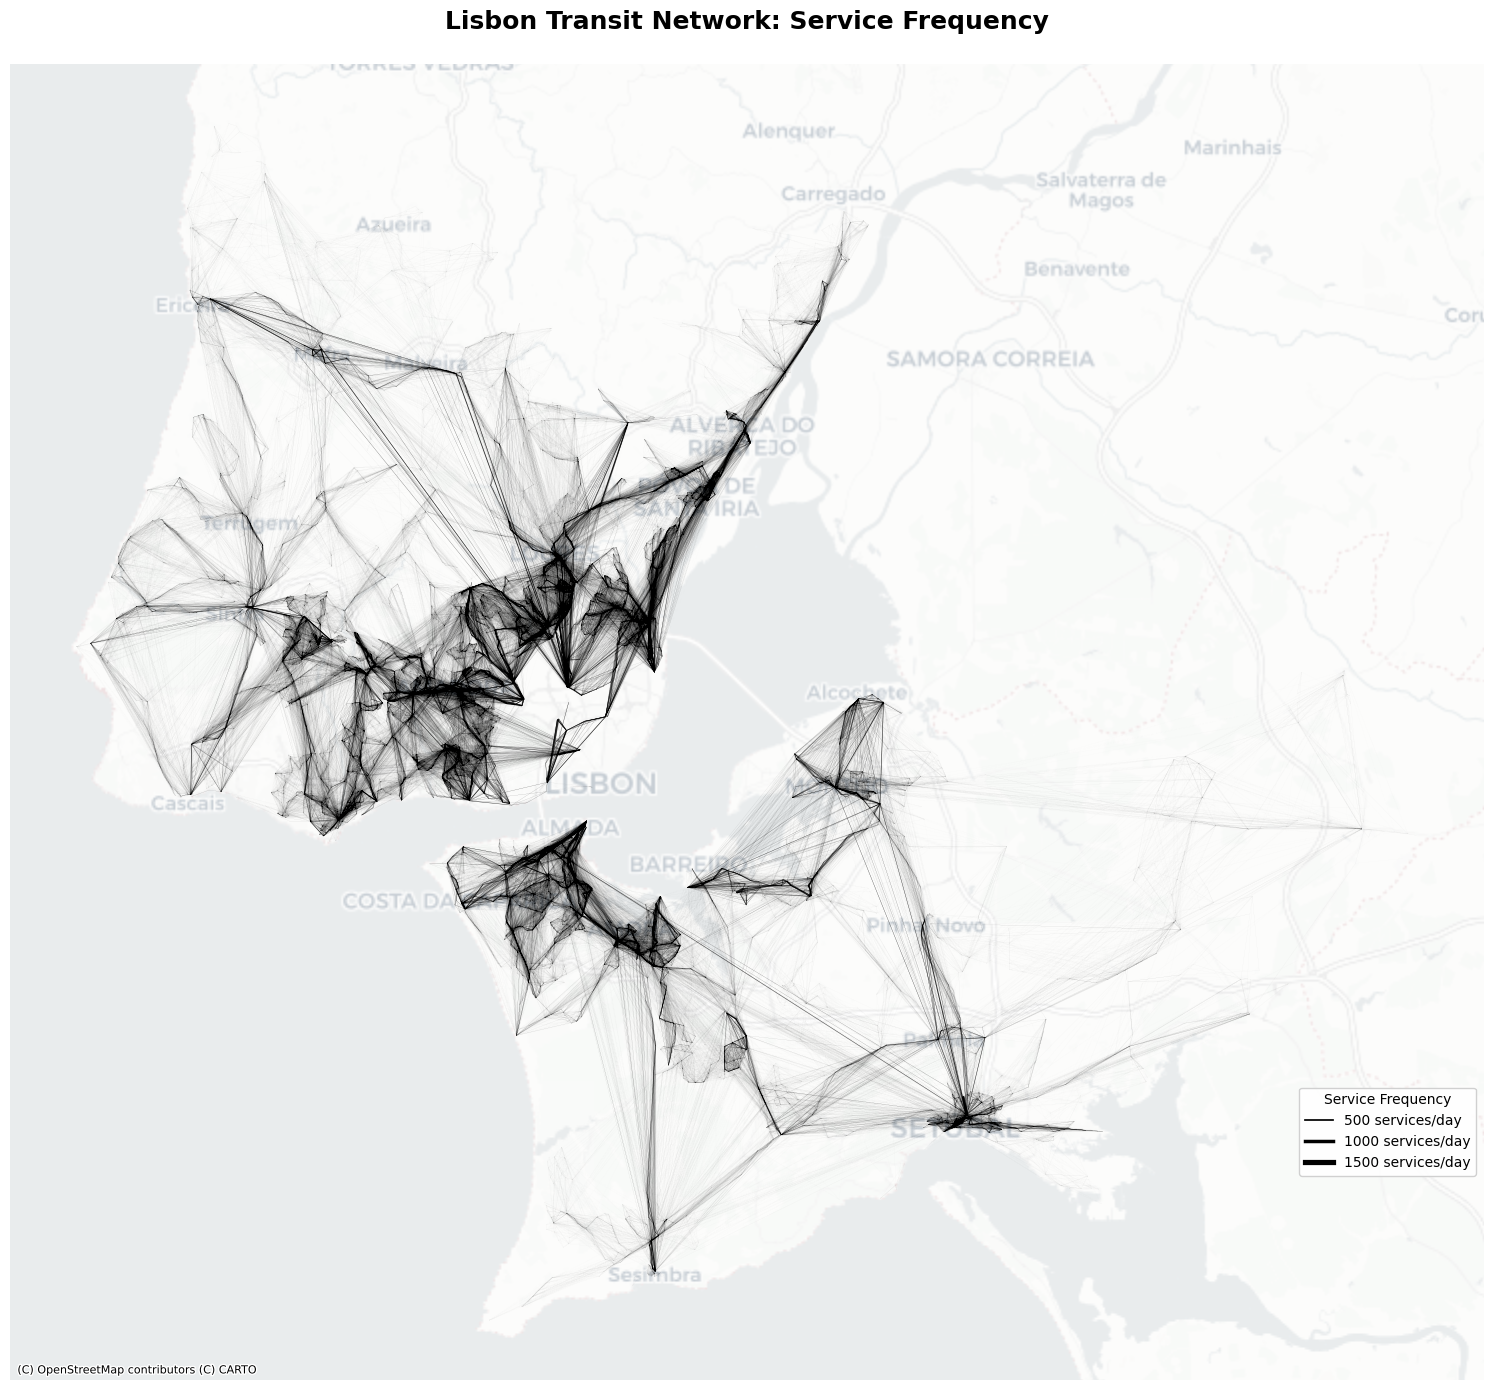

In [39]:
# Filter for reasonable edges (optional)
edges_for_viz = edges_in_bound[edges_in_bound["frequency"] > 0]

# Crop to city boundary
edges_cropped = gpd.sjoin(
    edges_for_viz,
    lisbon_boundary,
    how="inner",
    predicate="within"
)

print(f"Visualizing {len(edges_cropped):,} transit connections")
print("Features:")
print("   • Line color: Black (no travel time encoding)")
print("   • Line width: Service frequency (thicker = more frequent)")

# Set up figure
fig, ax = plt.subplots(figsize=(18, 14))

# Plot edges — black lines only, width by frequency
edges_cropped.plot(
    color="black",
    linewidth=edges_cropped['frequency'] / 400,  # adjust denominator if too thick/thin
    alpha=0.8,
    ax=ax
)

# Frequency legend
freq_values = [500, 1000, 1500]
freq_legend_elements = [
    mlines.Line2D([0], [0], color='black', linewidth=f/400, label=f'{f} services/day')
    for f in freq_values
]
freq_legend = ax.legend(
    handles=freq_legend_elements,
    title="Service Frequency",
    loc="lower right",
    bbox_to_anchor=(1, 0.15),
    frameon=True,
    framealpha=0.9
)

# Basemap
ctx.add_basemap(
    ax,
    crs=edges_cropped.crs.to_string(),
    source=ctx.providers.CartoDB.Positron,
    alpha=0.5
)

# Styling
ax.set_title("Lisbon Transit Network: Service Frequency",
             fontsize=18, fontweight='bold', pad=25)
ax.set_xlabel(""); ax.set_ylabel("")
ax.set_xticks([]); ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('#333333')

ax.set_aspect("equal")
ax.set_axis_off()
plt.tight_layout()

plt.show()



Visualizing 157,993 transit connections
Features:
   • Line color: Service frequency (cmap)
   • Line width: Service frequency (thicker = more frequent)


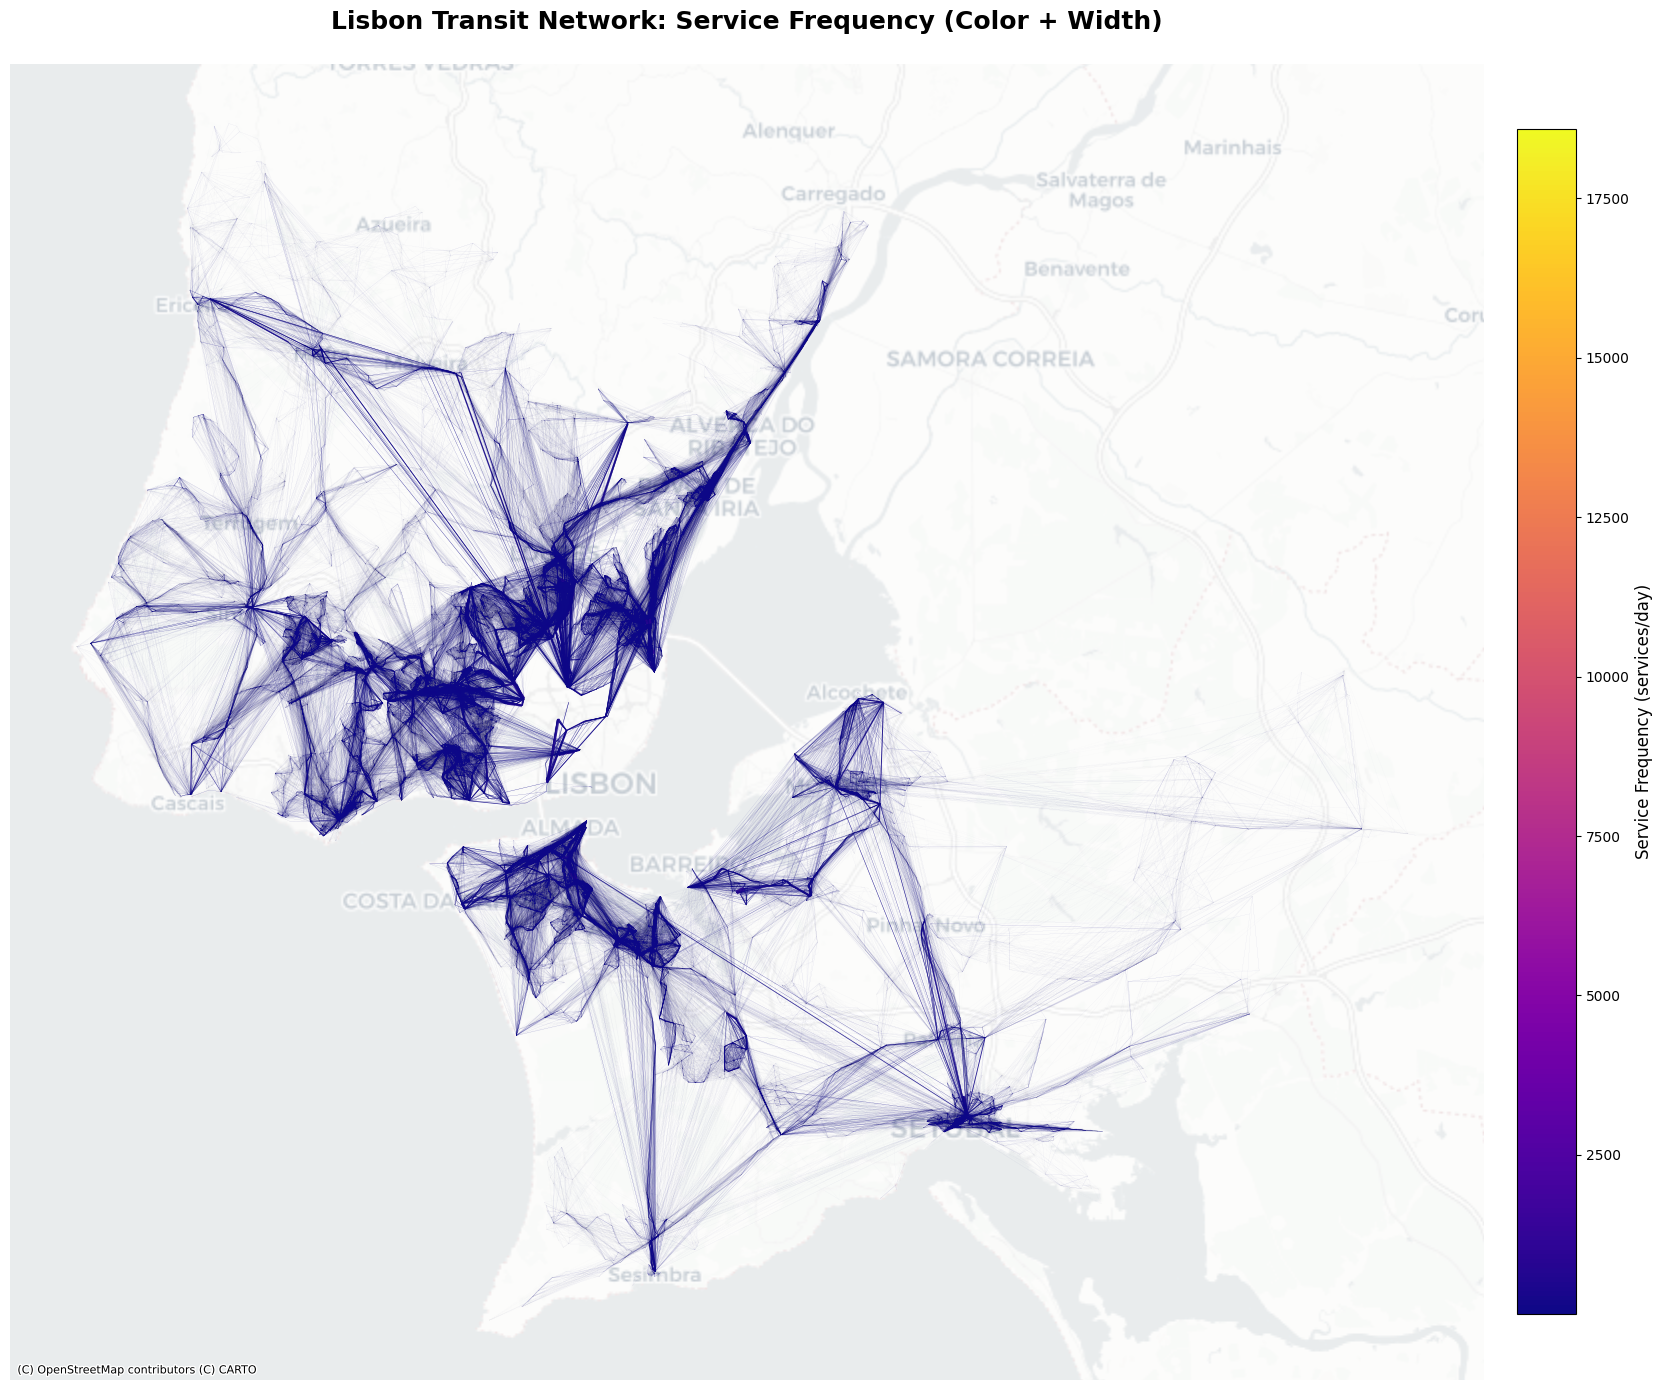

In [23]:
# Filter for reasonable edges (optional)
edges_for_viz = edges_in_bound[edges_in_bound["frequency"] > 0]

# Crop to city boundary
edges_cropped = gpd.sjoin(
    edges_for_viz,
    lisbon_boundary,
    how="inner",
    predicate="within"
)

print(f"Visualizing {len(edges_cropped):,} transit connections")
print("Features:")
print("   • Line color: Service frequency (cmap)")
print("   • Line width: Service frequency (thicker = more frequent)")

# --- Set up figure ---
fig, ax = plt.subplots(figsize=(18, 14))

# --- Create color map based on frequency ---
cmap = plt.cm.plasma  # try also 'viridis', 'inferno', or 'turbo'
norm = plt.Normalize(
    vmin=edges_cropped["frequency"].min(),
    vmax=edges_cropped["frequency"].max()
)

# --- Plot colorful lines ---
edges_cropped.plot(
    color=edges_cropped["frequency"].apply(lambda x: cmap(norm(x))),
    linewidth=edges_cropped["frequency"] / 250,  # thickness by frequency
    alpha=0.9,
    ax=ax
)

# --- Add colorbar legend for frequency ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # needed for older Matplotlib versions
cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("Service Frequency (services/day)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

# --- Add basemap ---
ctx.add_basemap(
    ax,
    crs=edges_cropped.crs.to_string(),
    source=ctx.providers.CartoDB.Positron,
    alpha=0.5
)

# --- Styling ---
ax.set_title("Lisbon Transit Network: Service Frequency (Color + Width)",
             fontsize=18, fontweight='bold', pad=25)
ax.set_xlabel(""); ax.set_ylabel("")
ax.set_xticks([]); ax.set_yticks([])

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('#333333')

ax.set_aspect("equal")
ax.set_axis_off()
plt.tight_layout()

plt.show()


In [40]:
# Convert to NetworkX graph for advanced network analysis
print("Converting to NetworkX for graph algorithms...")
travel_graph = city2graph.gdf_to_nx(travel_summary_nodes, travel_summary_edges)

print(f"NetworkX graph created:")
print(f"   • Nodes: {travel_graph.number_of_nodes():,}")
print(f"   • Edges: {travel_graph.number_of_edges():,}")
print(f"   • Graph type: {type(travel_graph).__name__}")

# Demonstrate city2graph's spatial filtering capabilities
print("\nApplying distance-based filtering...")
print("This showcases accessibility analysis - what's reachable within a distance?")

# Filter graph to show network within 1.2km of central London
central_london = lisbon_boundary.geometry.iloc[0].centroid
filtered_travel_graph = city2graph.filter_graph_by_distance(
    travel_graph,
    center_point=central_london,
    distance=3000,  # 1.2 km radius
    edge_attr="mean_travel_time"  # Filter by travel time, not physical distance
)

print(f"Filtered network (1.2km from center):")
print(f"   • Nodes: {filtered_travel_graph.number_of_nodes():,}")
print(f"   • Edges: {filtered_travel_graph.number_of_edges():,}")
print(f"   • Reduction: {(1 - filtered_travel_graph.number_of_nodes()/travel_graph.number_of_nodes())*100:.1f}%")

# Convert back to GeoDataFrames for visualization
filtered_travel_nodes, filtered_travel_edges = city2graph.nx_to_gdf(filtered_travel_graph)

print("Ready for focused network analysis and visualization!")

Removed 9493 invalid geometries


Converting to NetworkX for graph algorithms...
NetworkX graph created:
   • Nodes: 12,557
   • Edges: 141,432
   • Graph type: Graph

Applying distance-based filtering...
This showcases accessibility analysis - what's reachable within a distance?
Filtered network (1.2km from center):
   • Nodes: 9,261
   • Edges: 126,617
   • Reduction: 26.2%
Ready for focused network analysis and visualization!


Creating focused network visualization for central London...
This demonstrates city2graph's ability to combine spatial and network analysis
Detailed network analysis complete!
Focused analysis shows:
   • 9,261 transit stops
   • 126,617 direct connections
   • Network connectivity patterns in central London
   • Service frequency and travel time relationships


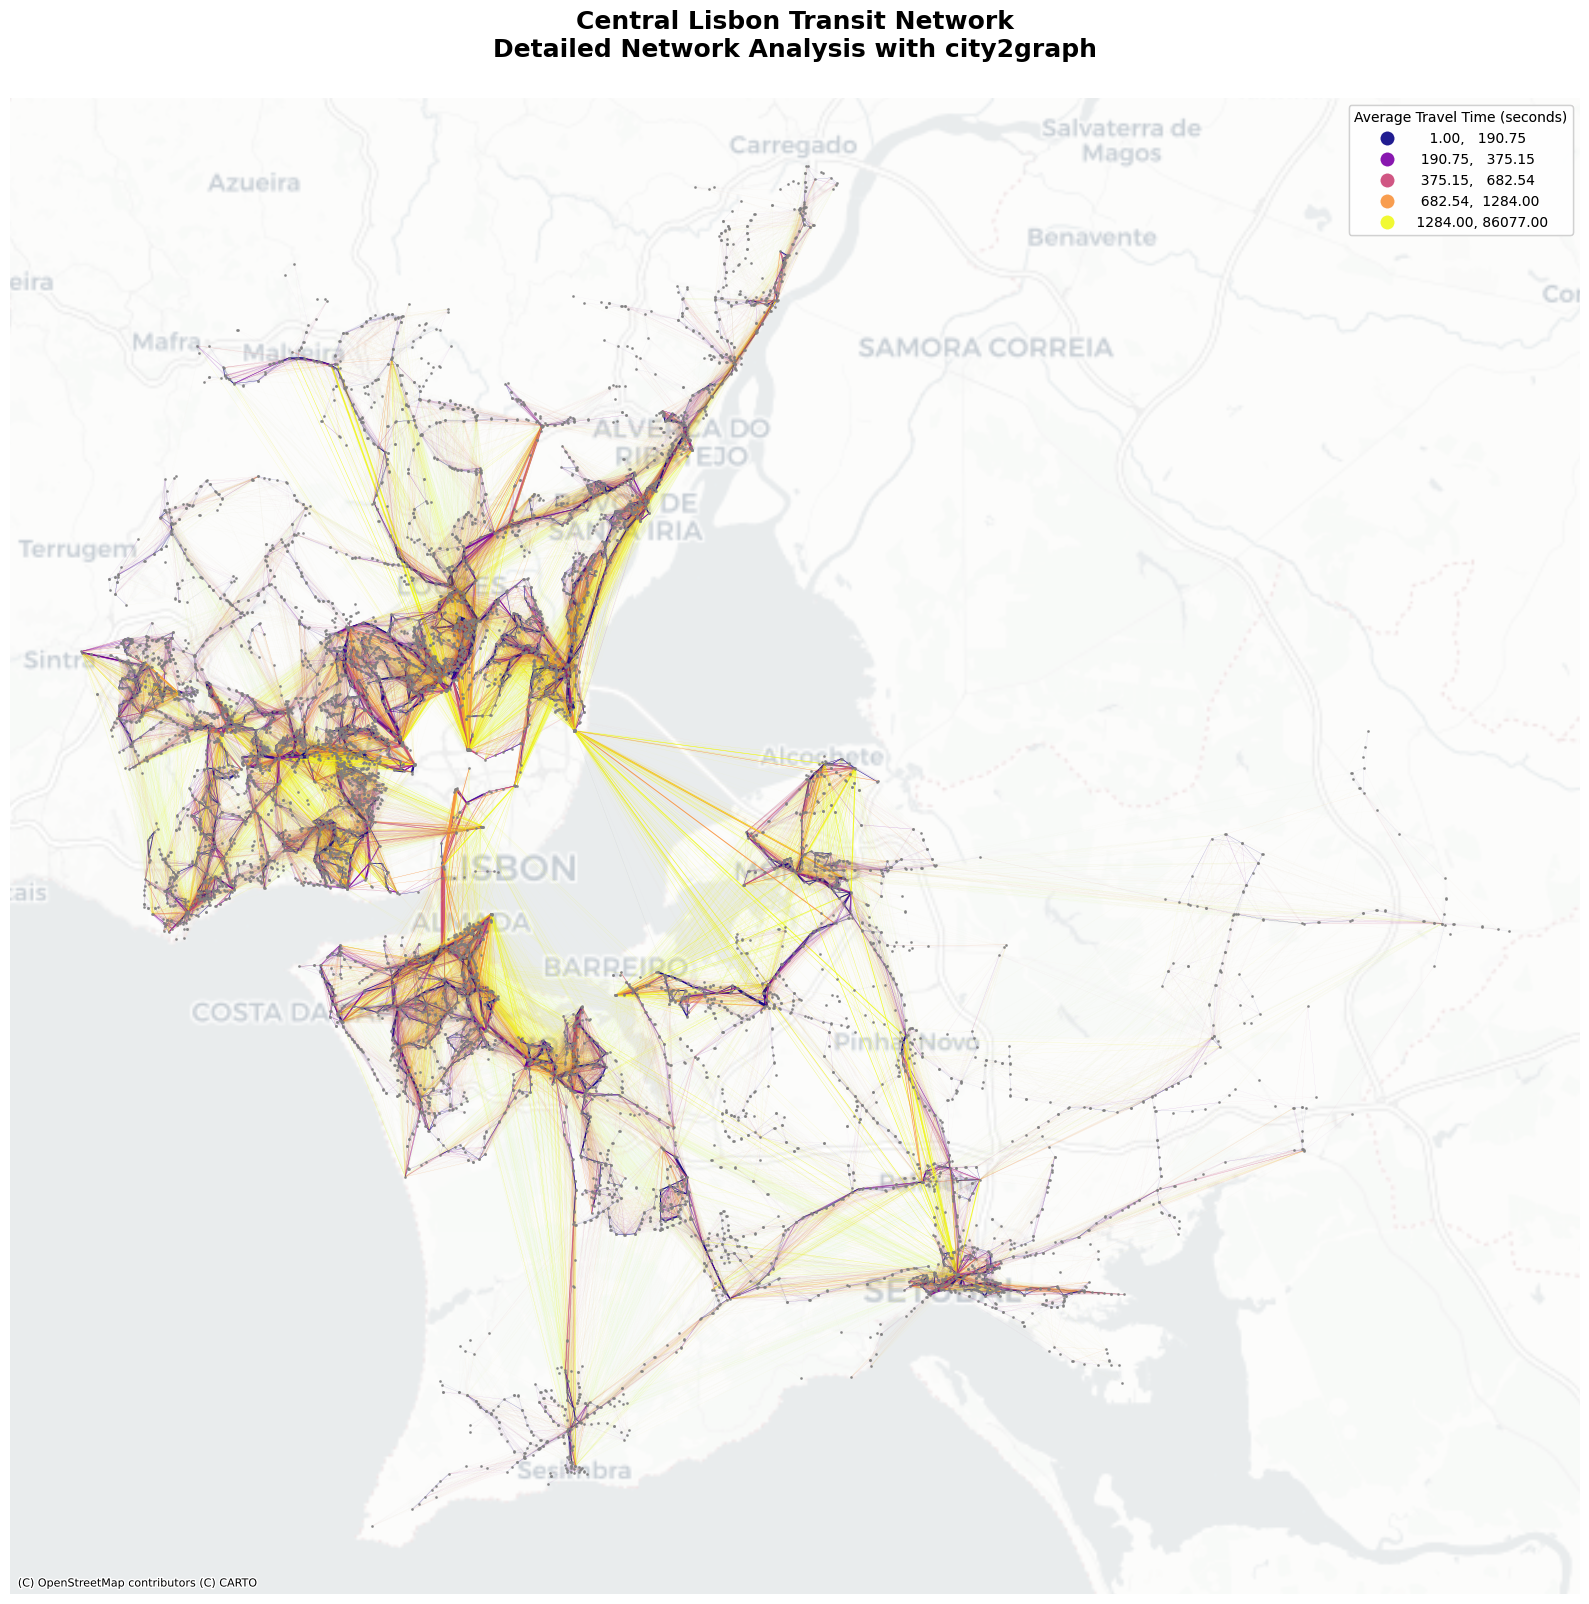

In [47]:
# Create a detailed view of central London's transit network
print("Creating focused network visualization for central London...")
print("This demonstrates city2graph's ability to combine spatial and network analysis")

# Set up the focused visualization
cmap = plt.cm.plasma
fig, ax = plt.subplots(figsize=(16, 16))

# Plot edges with enhanced styling
filtered_travel_edges.plot(
    column="mean_travel_time",
    cmap=cmap,
    scheme="quantiles",
    k=5,
    linewidth=filtered_travel_edges['frequency'] / 200,  # Adjusted for better visibility
    alpha=0.9,
    ax=ax,
    legend=True,
    legend_kwds={'title': 'Average Travel Time (seconds)', 'loc': 'upper right'}
)

# Highlight stops as network nodes
filtered_travel_nodes.plot(
    ax=ax,
    color="grey",
    #color='#ff6b6b',  # Bright red for visibility
    markersize=1,
    alpha=0.8,
    zorder=3
)

# Customize legends
travel_time_legend = ax.get_legend()
travel_time_legend.set_bbox_to_anchor((1, 1))
travel_time_legend.set_loc('upper right')

# Service frequency legend
freq_values = [300, 600, 900]
freq_legend_elements = [
    mlines.Line2D([0], [0], color='black', linewidth=f/200, label=f'{f} services/day')
    for f in freq_values
]
#freq_legend = ax.legend(
#    handles=freq_legend_elements,
#    title="Service Frequency",
#    loc="upper right",
#    bbox_to_anchor=(1, 0.8),
 #   frameon=True,
 #   framealpha=0.9
#)
ax.add_artist(travel_time_legend)

# Add basemap for geographic context
ctx.add_basemap(
    ax,
    crs=edges_cropped.crs.to_string(),
    source=ctx.providers.CartoDB.Positron,
    alpha=0.5
)

# Professional styling
ax.set_title("Central Lisbon Transit Network\nDetailed Network Analysis with city2graph",
             fontsize=18, fontweight='bold', pad=30)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

# Clean border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('#2c3e50')

ax.set_aspect("equal")
ax.set_axis_off()
plt.tight_layout()

print("Detailed network analysis complete!")
print(f"Focused analysis shows:")
print(f"   • {len(filtered_travel_nodes):,} transit stops")
print(f"   • {len(filtered_travel_edges):,} direct connections")
print(f"   • Network connectivity patterns in central London")
print(f"   • Service frequency and travel time relationships")

plt.show()

In [ ]:
# Calculate betweenness centrality for the filtered_travel_graph
betweenness = nx.betweenness_centrality(filtered_travel_graph, weight='mean_travel_time', normalized=True)

nx.set_node_attributes(filtered_travel_graph, betweenness, "betweenness_centrality")

In [48]:
filtered_travel_nodes, filtered_travel_edges = city2graph.nx_to_gdf(filtered_travel_graph)

Creating focused network visualization for Lisbon...
This demonstrates city2graph's ability to combine spatial and network analysis
Detailed network analysis complete!
Focused analysis shows:
   • 1,192 transit stops
   • 11,372 direct connections
   • Node color = betweenness centrality
   • Edge width = service frequency


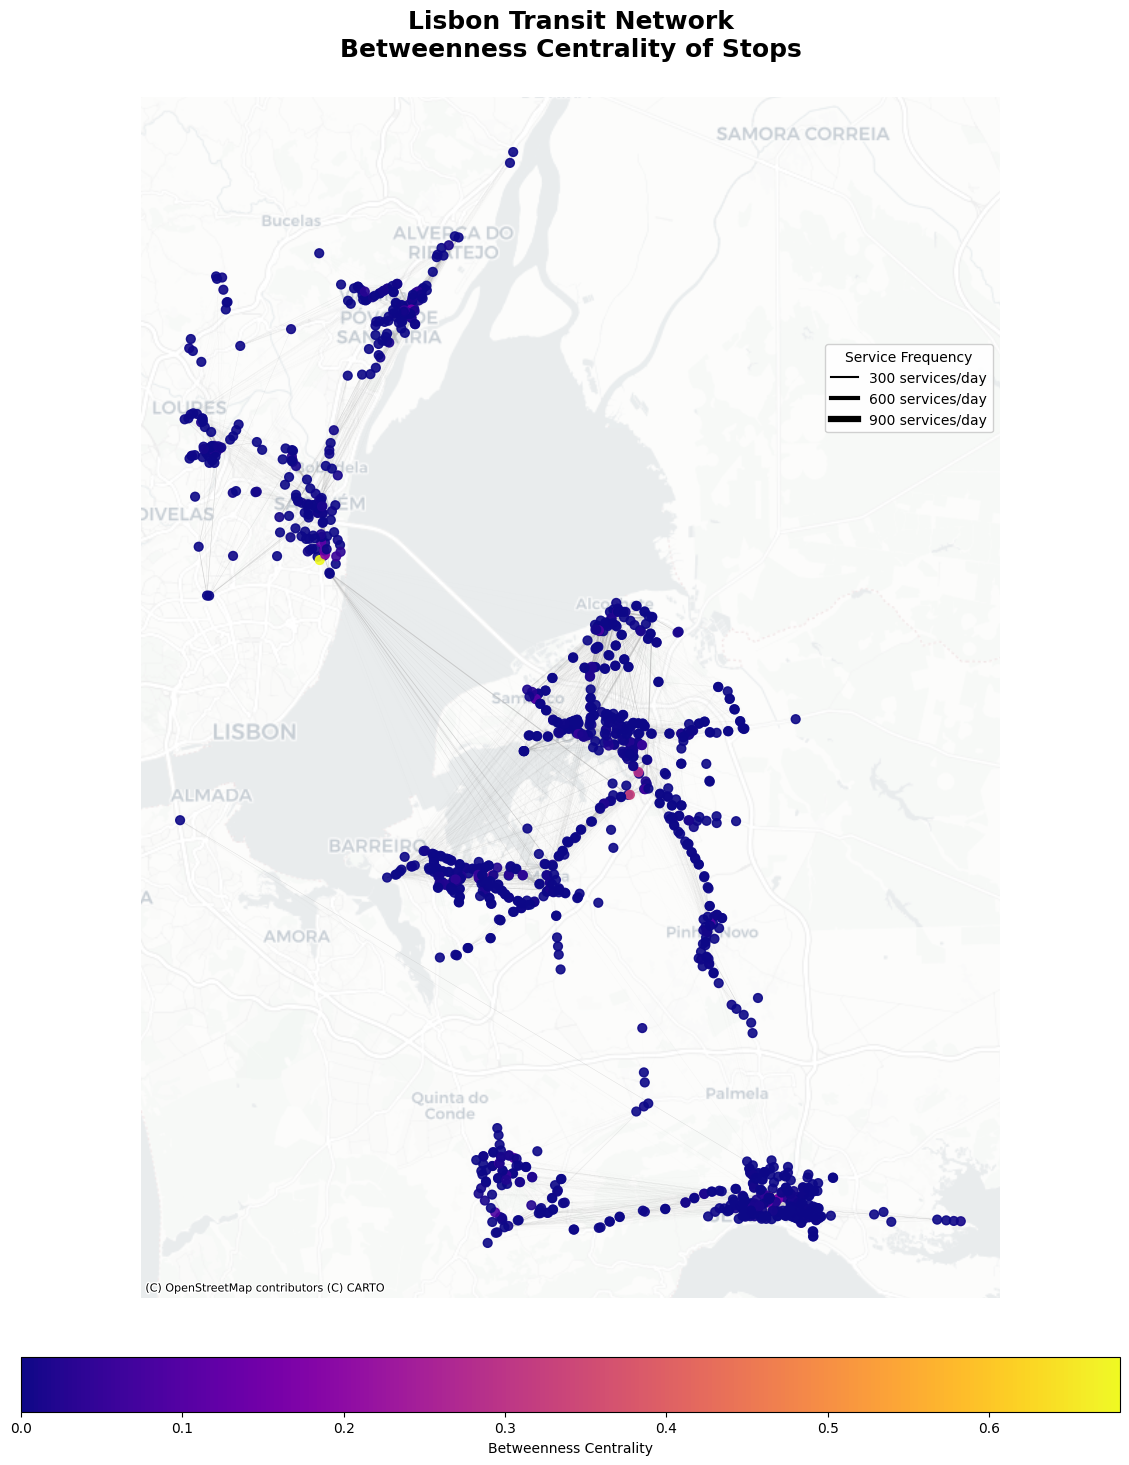

In [49]:
# Create a detailed view of central London's transit network
print("Creating focused network visualization for Lisbon...")
print("This demonstrates city2graph's ability to combine spatial and network analysis")

fig, ax = plt.subplots(figsize=(16, 16))

# Plot edges in a neutral color (no color encoding)
filtered_travel_edges.plot(
    ax=ax,
    color="#bbbbbb",
    linewidth=filtered_travel_edges['frequency'] / 200,
    alpha=0.7,
    zorder=1
)

# Plot nodes colored by betweenness centrality, with horizontal colorbar at the bottom
filtered_travel_nodes.plot(
    ax=ax,
    column="betweenness_centrality",
    cmap="plasma",
    markersize=40,
    alpha=0.9,
    legend=True,
    legend_kwds={
        'orientation': 'horizontal',
        'shrink': 0.7,
        'pad': 0.04,
        'label': 'Betweenness Centrality'
    },
    zorder=2
)

# Service frequency legend for edges
freq_values = [300, 600, 900]
freq_legend_elements = [
    mlines.Line2D([0], [0], color='black', linewidth=f/200, label=f'{f} services/day')
    for f in freq_values
]
freq_legend = ax.legend(
    handles=freq_legend_elements,
    title="Service Frequency",
    loc="upper right",
    bbox_to_anchor=(1, 0.8),
    frameon=True,
    framealpha=0.9
)

# Add basemap for geographic context
ctx.add_basemap(
    ax,
    crs=filtered_travel_edges.crs.to_string(),
    source=ctx.providers.CartoDB.Positron,
    alpha=0.5
)

# Professional styling
ax.set_title("Lisbon Transit Network\nBetweenness Centrality of Stops",
             fontsize=18, fontweight='bold', pad=30)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

# Clean border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('#2c3e50')

ax.set_aspect("equal")
ax.set_axis_off()
plt.tight_layout()

print("Detailed network analysis complete!")
print(f"Focused analysis shows:")
print(f"   • {len(filtered_travel_nodes):,} transit stops")
print(f"   • {len(filtered_travel_edges):,} direct connections")
print(f"   • Node color = betweenness centrality")
print(f"   • Edge width = service frequency")

plt.show()